In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests
import os
import json
import csv
import datetime
import dateutil.parser
import unicodedata
import time


import tweepy
from tweepy.auth import OAuthHandler
import configparser

from nltk.corpus import stopwords
import nltk
#nltk.download('stopwords')

import networkx as nx
import random

In [ ]:
#pip install tweepy --upgrade

### Twitter access

To compile the following cell you need to upload a "config.ini" file, including your own keys and tokens. You can easily get those with a twitter developer account.

In [ ]:
#Read "config.ini" file
config = configparser.ConfigParser()
config.read("config.ini")

#import keys and token
api_key = config["twitter"]["api_key"]
api_key_secret = config["twitter"]["api_key_secret"]
access_token = config["twitter"]["access_token"]
access_token_secret = config["twitter"]["access_token_secret"]

#Define api
auth = OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

"""
If authentication fails, you can try to uncomment these two lines

auth = tweepy.OAuth1UserHandler(api_key, api_key_secret, access_token, access_token_secret)
api = tweepy.API(auth)
"""

#Test authentication
try:
    api.verify_credentials()
    print('Successful Authentication')
except:
    print('Failed Authentication')

Successful Authentication


### 1) Trends analysis

This section will search for trend topic in a given area and show the most common words linked to them.

#### Get trends

WOEID list
*   Worldwide: 1
*   Italy: 23424853
*   France: 23424819
*   UK: 23424975

In [ ]:
#The following function returns a Pandas DataFrame with some information about trend topics in a given location
#The "i" argument manages how many trends will be analysed

def get_trends(WOEID, i=50):
    data = api.get_place_trends(WOEID)[0]["trends"]
    
    name = []
    promoted = []
    tweet_volume = []
    url = []
    
    for j in range(i):
        t = data[j]
        name.append(t["name"])
        promoted.append(t["promoted_content"])
        tweet_volume.append(t["tweet_volume"])
        url.append(t["url"])
    
    d = {"name" : name, "promoted" : promoted, "tweet_volume" : tweet_volume, "url" : url}
    return pd.DataFrame(d)

In [ ]:
#Top six trend topics in Italy

get_trends(23424853).head(6)

,name,promoted,tweet_volume,url
0,#Alluvione,None,12316.0,http://twitter.com/search?q=%23Alluvione
1,#16settembre,None,NaN,http://twitter.com/search?q=%2316settembre
2,#XF2022,None,14443.0,http://twitter.com/search?q=%23XF2022
3,#Federer,None,17524.0,http://twitter.com/search?q=%23Federer
4,#juvebenfica,None,NaN,http://twitter.com/search?q=%23juvebenfica
5,Orban,None,34525.0,http://twitter.com/search?q=Orban


#### Search

In [ ]:
#The following function return a Pandas DataFrame with some information about a given twitter search
#The "i" argument manages how many status will be analysed

#This function won't be used, but can be useful to explore data

def full_search(search, i):
    user_id = []
    screen_name = []
    name = []
    RT = []
    text = []
    loc = []
    lang = []
    time = []
        
    #In case of retweet get only the original text written by the user
    def get_text(user):
        try:
            text = user.retweeted_status.full_text
            RT = True
        except AttributeError:
            text = user.full_text
            RT = False
        return text, RT
    
    for j in range(i):
        user = search[j]
        user_id.append(user.user.id)
        screen_name.append(user.user.screen_name)
        name.append(user.user.name)
        loc.append(user.user.location)
        time.append(user.created_at) 
        lang.append(user.user.lang)
        text.append(get_text(user)[0])
        RT.append(get_text(user)[1])
        
        
    d = {"user_id" : user_id, "screen_name" : screen_name, "name" : name, "is a RT" : RT, "text" : text, 
           "loc" : loc, "lang" : lang, "time" : time}
    df = pd.DataFrame(d)
    return df

In [ ]:
#Filter out retweet 

def drop_RT(full_search):
    df = full_search[full_search["is a RT"] == False]
    return df

In [ ]:
#The following function searches for original tweets given a query
#The "i" argument manages how many status will be analysed

def text_search(query, i):
    RT = []
    text = []
        
    #In case of retweet get only the original text written by the user
    def get_text(utente):
        try:
            text = utente.retweeted_status.full_text
            RT = True
        except AttributeError:
            text = utente.full_text
            RT = False
        return text, RT
    
    #tweepy.Cursor manages to get more results than the standard api.search_tweets
    for status in tweepy.Cursor(api.search_tweets, q=query, tweet_mode="extended", lang="it", result_type="mixed").items(i):
        text.append(get_text(status)[0])
        RT.append(get_text(status)[1])
        
        
    d = {"is a RT" : RT, "text" : text}
    df = pd.DataFrame(d)
    return df

#### Text

In [ ]:
#The following function returns a list of the words in a given text
#It's similar to nltk.tokenize.word_tokenize

def tokenize(text):
    words = []
    stop = [" ", ".", ",", ";", "?", "!", ":", "'", "(", ")", "’", "\n", "https", "//t", "…", "-", "#"]
    
    word = ""
    for item in text:
        if item in stop:
            if word != "" and word not in stop:
                words.append(word)
            word = ""
        else:
            if word in stop:
                word = ""
            else: 
                word += item
    
    return words

In [ ]:
#The following function returns the frequencies for a given list of words

def count(words):
    done = []
    count = []
    
    for word in words:
        if word not in done:
            i = 0
            for w in words:
                if w == word:
                    i += 1
            count.append(i)
            done.append(word)
    
    df = pd.DataFrame(zip(done, count), columns = ["word", "frequency"])
    df = df.sort_values(by="frequency", ascending=False, ignore_index=True)
    return df

#### Analysis

In [ ]:
%%time

#Get Italy trend topics
trends = get_trends(23424853)

#In the result list will be stored the Pandas DataFrame with words and frequencies for a given trend
result = []

#This for cycle manages how many trends will be analysed
for i in range(6):
    
    #Research
    search = text_search(trends["name"][i], 100)
    search = drop_RT(search)

    #Get words
    words = []
    stop_words = stopwords.words("italian")

    #Drop stop_words
    for i in search.index:
        w = tokenize(search["text"][i])
        for j in w:
            if j not in stop_words:
                words.append(j.lower())
    
    #Count words and append to result
    result.append(count(words).head(10))

CPU times: user 1.11 s, sys: 63.9 ms, total: 1.17 s
Wall time: 10.2 s


#### Data visualization

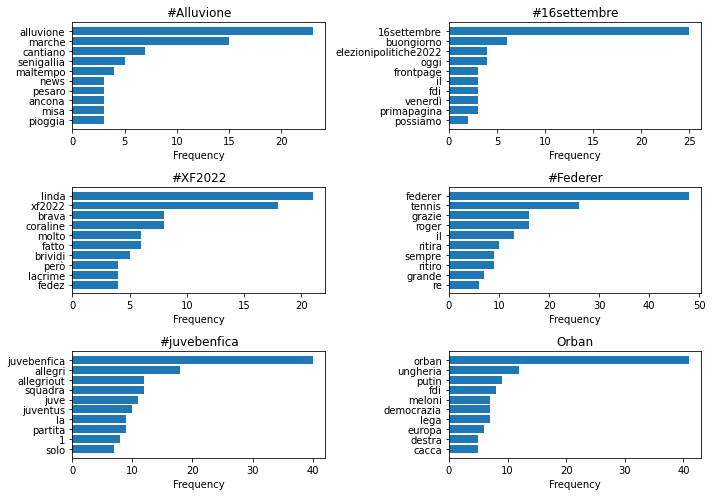

In [ ]:
#Horizontal bar plot for a given index of result list
def display_barh(i):
    plt.barh(result[i]["word"], result[i]["frequency"])
    plt.gca().invert_yaxis()
    plt.xlabel("Frequency")
    plt.title(trends["name"][i])

#Matplotlib plot
fig = plt.figure(1, figsize=(10, 7))
for k in range(6):
  ax = fig.add_subplot(3, 2, k+1)
  display_barh(k)
fig.tight_layout()
plt.show()


#### Comments for further analysis

Most important inductive biases of this analysis:
> result_type attribute of api.search_tweets function is set to "mixed", so the analysis will include both "popular" and "recent" tweets.

> This analysis does not consider retweets. You could be interested in a system of weights based on popularity. 

(Some of the many possible) improvements: 
> Stop words should be extended

> Should be better investigated the time dependence of results and what's the best amount of tweets to be considered. 

> Would be interesting to combine this simple code with some ML tool for sentiment analysis.








### 2) Networks and graphs

This section will show relationships between twitter users quantified by a given function. 

#### Define distance

The distance between two users is here based on people who both follow. It's quantified by the following formula:

$dist(user_1, user_2) = \frac{\#(F_1 \cap F_2)}{\#(F_1)+\#(F_2)-\#(F_1 \cap F_2)}$, where $F_i$ indicates users followed by $user_i$.

In [ ]:
#This function returns the above defined distance between two given friends lists.

def dist(friends_1, friends_2):    
    com = 0
    for user in friends_1:
        if user in friends_2:
            com = com + 1
    
    try:
        weight = com/(len(friends_1)+len(friends_2)-com)
    except ZeroDivisionError:
        weight = 0
    
    return weight

#### Read previous analyzes

In [ ]:
#This function read or create a .csv file as a Pandas DataFrame in order to get previous analyzes.

def open_graph_df(file_name):
    try: 
        df = pd.read_csv(file_name)
        print("open " + file_name)
    except FileNotFoundError:
        df = pd.DataFrame({"user1" : [], "user2" : [], "weight" : []})
        df.to_csv(file_name, index = False)
        print("created " + file_name)
    return df
        
df = open_graph_df("graph_df.csv")

open graph_df.csv


#### Analysis

The following cell stores new data in the Pandas DataFrame. 

The algorithm is pretty simple: get a user id (starting id is mine), choose $k$ random twitter friends, calculate the distances, choose a random user between the three friends, iterate the process $i$ times.

Runtimes are long because the twitter rate limitations. Save the Pandas DataFrame as a .csv file is useful to continue the analysis in different sessions.

In [ ]:
%%time

#Define variable 
i = 0
value_error = 0
error = 0
user_id = 830001493172449282 #starting id

k = 3
while i < 50:
    #Try to get user's friends
    try:
        friends = api.get_friend_ids(user_id=user_id)
        
        #Try to get a k-sample of random friends
        try:
            friends_sample = random.sample(friends, k)
            
            #Calculate distances between k couples of users
            for user in friends_sample:
                friends_2 = api.get_friend_ids(user_id=user)
                new_edge = pd.DataFrame({"user1" : [user_id], "user2" : [user], "weight" : [dist(friends, friends_2)]})
                df = pd.concat([df, new_edge], axis=0, ignore_index = True)        
        
        #Store errors given by random.sample
        except ValueError:
            value_error = value_error + 1

        #Choose new starting id
        user_id = random.sample(friends_sample, 1)[0]
        
        #Uncomment to get un idea of the process
        if i in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]: print(i)
    
    #Store errors given by authentication
    except:
        error = error + 1

    i = i + 1

#### Save results and further analysis

In [ ]:
#Update .csv file
df.to_csv("graph_df.csv", index = False)

In [ ]:
#Open .csv file as a Pandas Dataframe
df_graph = open_graph_df("graph_df.csv")

open graph_df.csv


In [ ]:
#Compose the distance function with the exponential function to emphasize the differences
df_graph = df_graph.assign(weight_exp=np.exp(df_graph["weight"]))
df_graph.tail(2)

,user1,user2,weight,weight_exp
284,1088147520109404160,2484185263,0.030965,1.031450
285,1088147520109404160,318119463,0.005040,1.005053


#### Data visualization

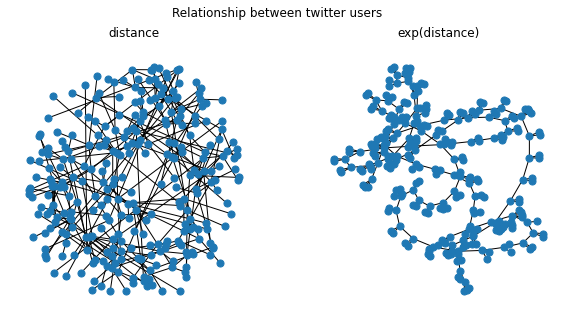

In [ ]:
#Create networkx graph
D = nx.from_pandas_edgelist(df_graph, 'user1', 'user2', ['weight'])
D_exp = nx.from_pandas_edgelist(df_graph, 'user1', 'user2', ['weight_exp'])

#Matplotlib plots
plt.figure(figsize=(10, 5))
plt.suptitle("Relationship between twitter users")
plt.subplot(121)
nx.draw(D, node_size = 50)
plt.title("distance")

plt.subplot(122)
nx.draw(D_exp, node_size= 50)
plt.title("exp(distance)")
#plt.savefig('graph.png', bbox_inches='tight')
plt.show()

#### Comments for further analysis

Most important inductive biases:
> Of course the definition of distance between users.

> The two hyperparameters that manage the for cycle: $i$ number of iterations, $k$ friends choose for iteration. 

> The random.sample algorithm.

(Some of the many possible) improvements:
> Should be better investigate the rule of hyperparameters.

> This approach is very time expensive in order to get some significant results. Might be better to use a more structured sample algorithm. 

> In general, I have an approximately zero experience with networks and that was only a game during my holidays. 












